In [1]:
import os
import numpy as np

from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
import xml.etree.ElementTree as ET

APPLY_LINES_THRESHOLD = True
LINES_THRESHOLD = 500
log_mapping = {
    '2018-06-30-08': [],
    '2018-06-30-09': [],
    '2018-06-30-10': []
}
log_messages = []

def process_log_entry(log):
    messages = []
    
    metainfo = log.findall("./metainfo")
    for meta in metainfo:
        messages.append(meta.text)
        
    stacktrace = log.findall("./stacktrace")
    
    for stack in stacktrace:
        messages.append(stack.text)
        
    if len(messages) > 0:
        return ' '.join(messages)
    
    return None

def process_xml(xml_str, file_name):
    root = ET.fromstring(xml_str)
    
    log_entry = process_log_entry(root)
    
    if log_entry is not None:
        key = ''
        if '2018-06-30-08' in file_name:
            key = '2018-06-30-08'
        elif '2018-06-30-09' in file_name:
            key = '2018-06-30-09'
        elif '2018-06-30-10' in file_name:
            key = '2018-06-30-10'
            
        log_mapping[key].append(len(log_messages))

        log_messages.append(log_entry)

for file in os.listdir('logs'):
    current_file = os.path.join('logs', file)
    with open(current_file, "r", encoding="latin-1") as log:
        print('Processing {}'.format(current_file))
        local_count = 0
        
        current_xml = ''
        for line in log:
            local_count += 1
            if APPLY_LINES_THRESHOLD == True and local_count > LINES_THRESHOLD:
                continue
            
            if '<logrecord>' in line and '</logrecord>' in line:
                current_xml = ''
                process_xml(line, current_file)

            elif '<logrecord>' in line:
                if len(current_xml) > 0:
                    process_xml(current_xml, current_file)
                current_xml = line

            elif '</logrecord>' in line:
                current_xml += line
                process_xml(current_xml, current_file)
                current_xml = ''

            else:
                current_xml += line

Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-10.1
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-09
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-08.3
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-10.3
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-09.2
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-09.1
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-08
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-10.2
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-09.3
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-09.4
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-10.4
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-10
Processing logs/Website_40.5.1008_9001_xml.log.2018-06-30-08.4


In [3]:
len(log_messages)

493

In [4]:
import LSH
import TFIDF

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
%%time
lsh = LSH.LSH()
similarity = lsh.get_similarity(log_messages, 'en')

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
CPU times: user 52.3 s, sys: 419 ms, total: 52.8 s
Wall time: 53.5 s


In [7]:
def print_similarity(similarity, text_lst, file_name, col_width=6):
    col_width = col_width + len('text')
    def format_sim(sim):
        if type(sim) == float:
            formated_sim = "{:.2f}".format(sim)
        elif sim is None or type(sim) == str:
            formated_sim = ' '*col_width
        return formated_sim.ljust(col_width)

    file = open(file_name,'w') 
    col_names = [("text" + str(i)).ljust(col_width) for i in range(len(text_lst)) ]
    col_names = "  ".join(col_names)
    file.write("{}{}\n".format(" "*(col_width+1), col_names))

    divisors = ["-"*col_width for i in range(len(text_lst))]
    divisors = "  ".join(divisors)
    file.write("{}{}\n".format(' '*(col_width+1), divisors))

    for i, row in enumerate(similarity):
        row_name = ("text" + str(i)).ljust(col_width)
        formated_sims = list(map(format_sim, row))
        row = "  ".join(formated_sims)
        file.write("{}{}{}\n".format(row_name, "|", row))
        
    file.close()

In [8]:
print_similarity(similarity, log_messages, 'similarity_1.txt', col_width=len(str(len(log_messages))))

In [9]:
similarity_matrix = np.array(similarity)

In [11]:
groups = {}
assigned = []
SIMILARITY_THRESHOLD = 0.5

for r, row in enumerate(similarity_matrix):
    if r in assigned:
        continue
    ind = [(i,sim) for i, sim in enumerate(row) if sim is not None and sim > SIMILARITY_THRESHOLD]
    
    group_id = 'group_'+ str(len(groups))
    groups[group_id] = { 'idx': r, 'items': ind, 'text': log_messages[r]}
    groups[group_id]['items'].append((r, 1.0))
    
    assigned.append(r)
    for item_idx, _ in ind:
        assigned.append(item_idx)
        
    #print(r,'|',ind)

In [12]:
check_similar = [groups[key] for key, val in groups.items() if len(val['items']) > 1]

In [13]:
check_similar

[{'idx': 105,
  'items': [(117, 0.84), (118, 0.79), (105, 1.0)],
  'text': 'LogRequestFailure message: No Long Token\n-- HEADERS --\nContent-Length: 0\nCookie: gpv_pn=cnw%3ADocument%3AI8aaf160251cd11dfb1a49773c922d457%3AView%3AFullText; s_cc=true; BIGipServerprod_apache_a=2050676490.10787.0000; SessionStorage=%7B%22ReqWindow%22%3A3%2C%22ActiveReqs%22%3A3%7D; TS0152b04c=019e0f65f48788a86e6f8d6eb5f0ab0a0c682da9f1616949b1f996d2b407be937ba942adcd2033d171f5fba62f94bb7d2cca5a34a9; TS01cde927=019e0f65f43d40fe4825f5a8f2466287769c386d64505aa7efe3d2b2347682327207027534ae3e98bf643a1c5c2c483091ca4c083ca6142473c3787ff256d516950bb1da691593ef460fe834e6fa41a8eef7fddb2e; AMCVS_A7D63BC75245AE300A490D4D%40AdobeOrg=1; AMCV_A7D63BC75245AE300A490D4D%40AdobeOrg=1099438348%7CMCIDTS%7C17713%7CMCMID%7C15804029632425564761935462236849527380%7CMCAID%7CNONE%7CMCOPTOUT-1530324000s%7CNONE%7CvVersion%7C2.1.0; _ga=GA1.2.1446579989.1530316800; _gat=1; _gid=GA1.2.1382732952.1530316800;ig=prod_a_2;site=a;web_pm=10.215.58

In [14]:
print(log_messages[33])
print()
print(log_messages[76])

Firm Integration URL returned an error from AccountPreferences when getting the firm info for office id 1000583124: Error creating AccessControlToken. There is no SeamlessAuthenticationToken on the UDS Session.

Firm Integration URL returned an error from AccountPreferences when getting the firm info for office id 1000309093: Error creating AccessControlToken. There is no SeamlessAuthenticationToken on the UDS Session.


In [30]:
colors_to_exclude = [
    'whitesmoke','floralwhite','lightgoldenrodyellow',
    'aliceblue', 'w','seashell','ivory','ghostwhite',
    'white','beige','azure','lavender','snow','linen',
    'antiquewhite','oldlace','papayawhip','cornsilk','lightyellow','mintcream',
    'lavenderblush','red'
]
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
color_names = [key for key,_ in colors.items() if key not in colors_to_exclude]
#print(color_names)

In [21]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def get_log_counts_per_period(period, log_mapping, groups):
    items = log_mapping[period]
    
    counts = [len(intersection([it for it,_ in groups['group_'+str(i)]['items']], items)) for i in range(len(groups))]
    
    return counts

In [22]:
def draw_legend(groups):
    n = len(groups)
    ncols = 1
    nrows = n // ncols + 1

    fig, ax = plt.subplots()
    ax.figure.set_size_inches(50, 50)

    # Get height and width
    X, Y = fig.get_dpi() * fig.get_size_inches()
    h = Y / (nrows + 1)
    w = X / ncols

    for i in range(len(groups)):
        col = i % ncols
        row = i // ncols
        y = Y - (row * h) - h

        xi_line = w * (col + 0.05)
        xf_line = w * (col + 0.25)
        xi_text = w * (col + 0.3)

        group_id = 'group_{}'.format(str(i))
        text = '{}: {} ({} items in this group)'.format(group_id, groups[group_id]['text'].replace('\n','')[:80], len(groups[group_id]['items']))

        ax.text(xi_text, y, text, fontsize=(h * 0.8),
                horizontalalignment='left',
                verticalalignment='center')

        ax.hlines(y + h * 0.1, xi_line, xf_line,
                  color=color_names[i % len(color_names)], linewidth=(h * 0.6))

    ax.set_xlim(0, X)
    ax.set_ylim(0, Y)
    ax.set_axis_off()

    fig.subplots_adjust(left=0, right=1,
                        top=1, bottom=0,
                        hspace=0, wspace=0)
    plt.show()

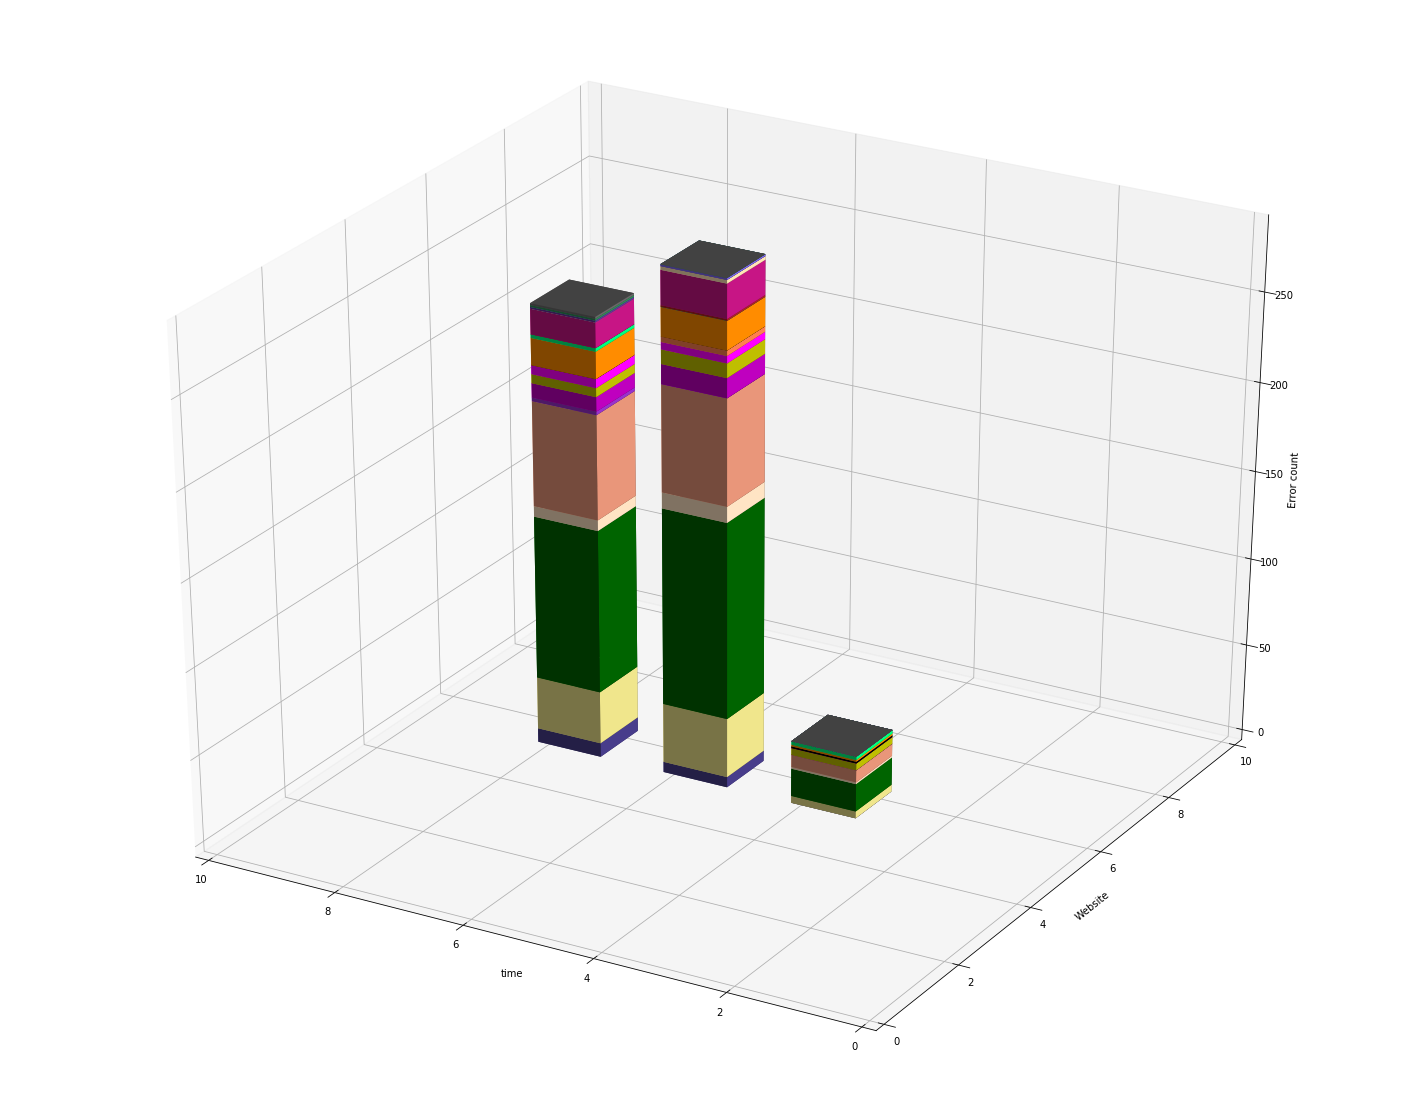

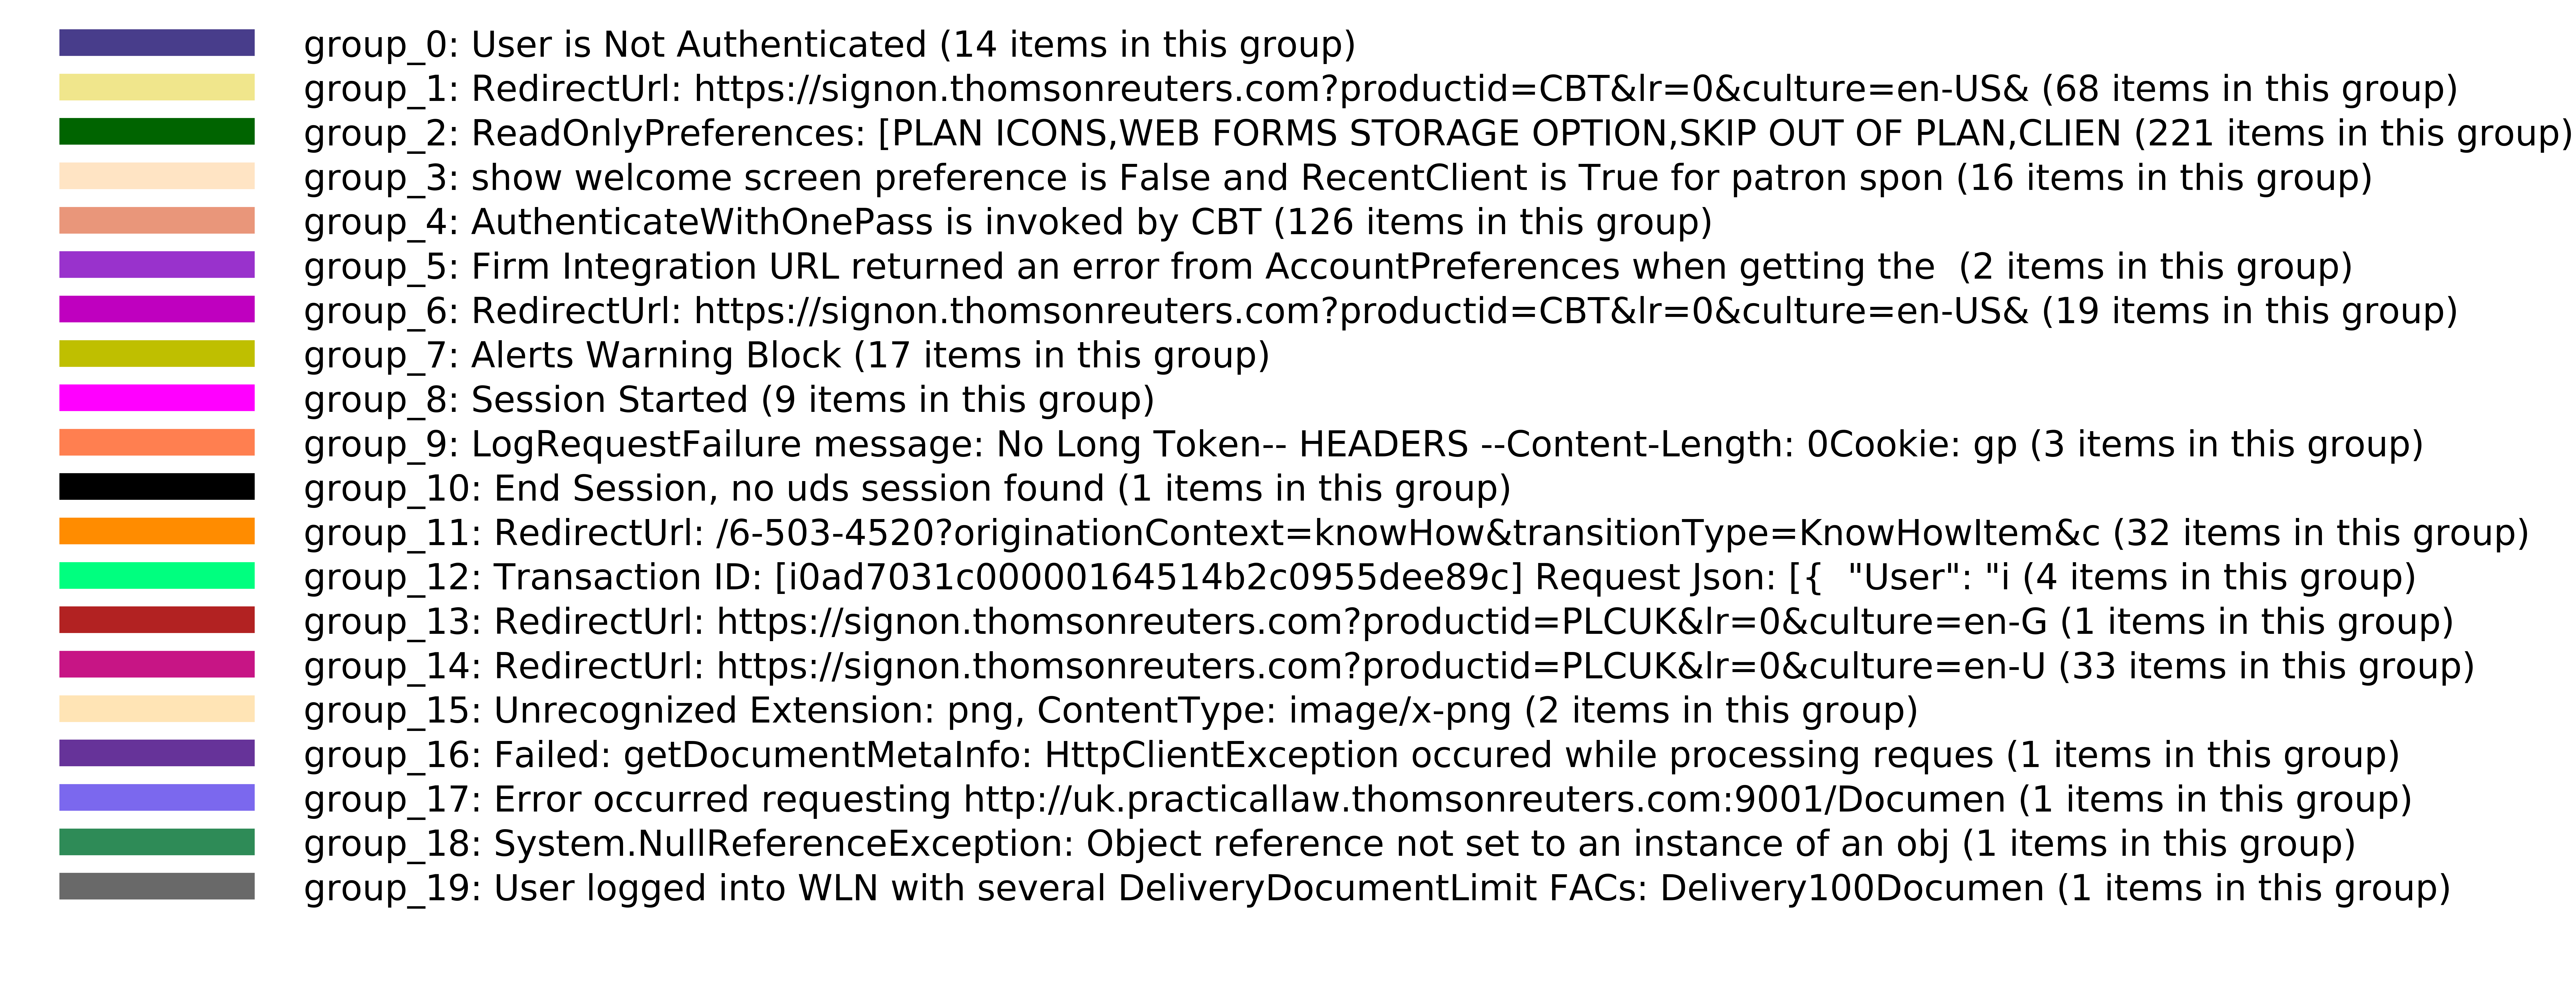

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")
ax.figure.set_size_inches(25, 20)

ax.set_xlabel("time")
ax.set_ylabel("Website") 
ax.set_zlabel("Error count")
ax.set_xlim3d(0,10)
ax.set_ylim3d(0,10) 

xpos = [3,5,7]
ypos = [5,5,5]
zpos = np.zeros(3)

dx = np.ones(3)
dy = np.ones(3)
dz = np.array([get_log_counts_per_period(period, log_mapping, groups) for period in ['2018-06-30-08','2018-06-30-09','2018-06-30-10']])

_zpos = zpos   # the starting zpos for each bar

for i in range(len(groups)):
    c = color_names[i % len(color_names)]
    #print(c)
    ax.bar3d(xpos, ypos, _zpos, dx, dy, dz[:,i], color=c)
    _zpos += dz[:,i]    # add the height of each bar to know where to start the next
    
plt.gca().invert_xaxis()
plt.show()

draw_legend(groups)

In [32]:
groups['group_18']

{'idx': 394,
 'items': [(394, 1.0)],
 'text': 'System.NullReferenceException: Object reference not set to an instance of an object.\n   at Cobalt.Website.Platform.Web.CobaltControllerActionInvoker.FindAction(ControllerContext controllerContext, ControllerDescriptor controllerDescriptor, String actionName) in D:\\Builds\\794\\Cobalt Website\\WebsiteBranch\\src\\App\\Website\\CobaltControllerActionInvoker.cs:line 89\n   at System.Web.Mvc.ControllerActionInvoker.InvokeAction(ControllerContext controllerContext, String actionName)\n   at System.Web.Mvc.Controller.<>c__DisplayClass1d.<BeginExecuteCore>b__19()\n   at System.Web.Mvc.Async.AsyncResultWrapper.<>c__DisplayClass1.<MakeVoidDelegate>b__0()\n   at System.Web.Mvc.Controller.EndExecuteCore(IAsyncResult asyncResult)\n   at System.Web.Mvc.Async.AsyncResultWrapper.<>c__DisplayClass4.<MakeVoidDelegate>b__3(IAsyncResult ar)\n   at System.Web.Mvc.MvcHandler.<>c__DisplayClass8.<BeginProcessRequest>b__3(IAsyncResult asyncResult)\n   at System

In [ ]:
groups['group_8']